<blockquote> Привет! Так я буду отмечать свои вопросы. </blockquote> 

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [54]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
# sns.set_context('notebook')
# sns.set_style()

sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid')

# Обновление требуется для доступа к sns.histplot()
%pip install seaborn==0.11.2

In [2]:
# init_df - датафрейм в исходном виде
init_df = pd.read_csv('/datasets/data.csv')

# df - датафрейм для преобразования
df = pd.read_csv('/datasets/data.csv')

*Значения колонок*

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

In [3]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


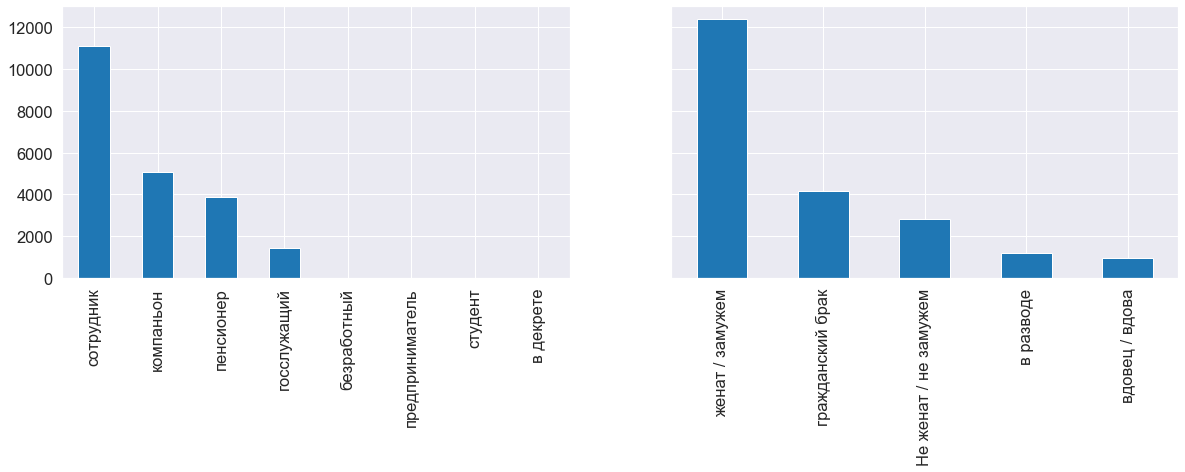

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

df['income_type'].value_counts().plot.bar(ax=ax1)
df['family_status'].value_counts().plot.bar(ax=ax2)

plt.show()

- При первом знакомстве с данными видны проблемы в колонке `days_employed`: некоторые значения отрицательные
- В колонках `days_employed` и `total_income` есть пропуски, при этом их количество одинаково в обеих колонках. Обе колонки содержат данные вещественного типа.
- В таблице представлено 8 разных типов занятасти заемщиков, основной вклад приходится на `сотрудников`, `компаньонов`, `пенсионеров` и `госслужащих`. Более половины клиентов женаты/замужем. _Это предварительные оценки, которые могут измениться после обработки пропусков и дубликатов **(проверить)**._

**Вывод**

В данных есть проблемы, их природу необходимо исследовать прежде чем приступать к анализу

## Шаг 2. Предобработка данных

После предварительного ознакомления с данными кажется, что прежде всего внимание нужно уделить отрицательным значениям в колонке `days_employed`.

Чем можно объяснить их появление?

In [6]:
# Таблица с отрицательным трудовым стажем
neg_days_df = df[df['days_employed'] <= 0]

# Таблица с положительным трудовым стажем
pos_days_df = df[df['days_employed'] > 0]

neg_days_df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
...,...,...,...,...,...,...,...,...,...,...,...,...
21519,1,-2351.431934,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [7]:
print(f'Доля отрицательных значений days_employed среди всех значений days_employed: {neg_days_df.shape[0] / df.shape[0]:.0%}')

Доля отрицательных значений days_employed среди всех значений days_employed: 74%


Посмотрим на них внимательнее.

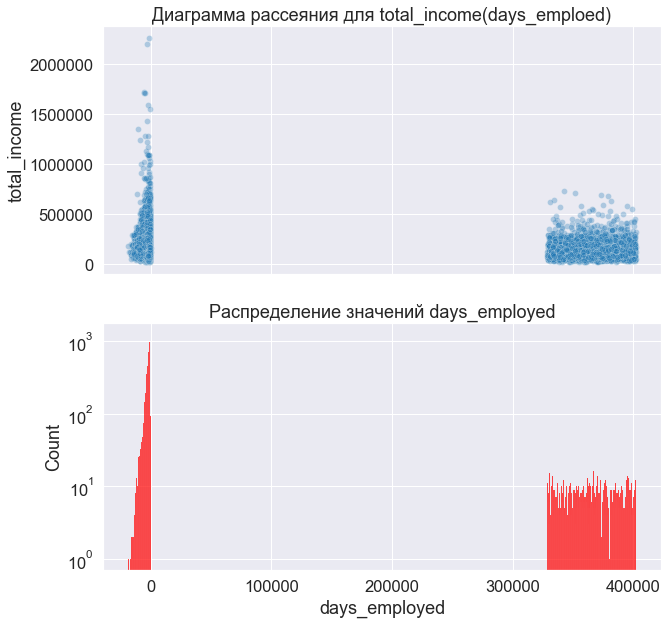

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.scatterplot(data=df, x='days_employed', y='total_income', ax=ax1, alpha=.3)
ax1.set_title('Диаграмма рассеяния для total_income(days_emploed)')

h = sns.histplot(data=df, x='days_employed', ax=ax2, color='red')
h.set_yscale("log")
ax2.set_title('Распределение значений days_employed')

plt.show()

Видно, что данные разбиты на две группы, сильно отстоящие друг от друга. На верхней панели видно, что разброс значений ежемесячного дохода в группе слева заметно больше.

На нижней панели видно, что распределения значений `days_employed` в этих группах сильно отличаются. Построю эти распределения на отдельных графиках и переведу дни в года.

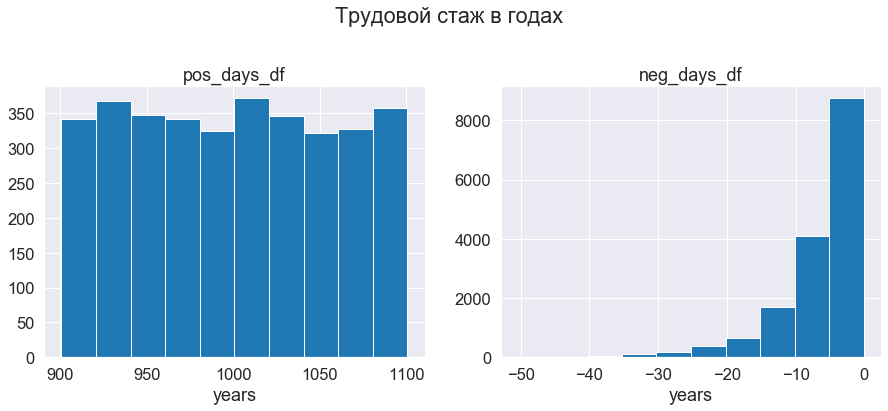

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(pos_days_df['days_employed'] / 365)
ax1.set_xlabel('years')
ax1.set_title('pos_days_df')

# ax1.set_yscale('log')

ax2.hist(neg_days_df['days_employed'] / 365)
ax2.set_xlabel('years')
ax2.set_title('neg_days_df')

fig.suptitle('Трудовой стаж в годах', y=1.1)

plt.show()

Трудовой стаж в 1000 лет $-$ можно смело повышать пенсионный возраст в стране.

Из гистограм выше можно сделать такие выводы:

- Положительные значения в колонке `days_employed` (левая панель) не вызывают доверия по двум причинам. Во-первых, они слишком большие (порядка $10^3$). Во-вторых, можно выдвинуть гипотезу о том, что эти данные порождены равномерным распределением (т. е. клиенты берут кредит одинаково часто независимо от своего трудового стажа).
- Отрицательные значения `days_employed` лежат в диапазоне от 0 до ~35. Если взять их модуль, то получится, что с увеличением трудового стажа клиенты реже обращаются за кредитом. Такое поведение кажется адекватным: люди с б**о**льшим трудовым стажем с б**о**льшей вероятностью пользуются собственными накоплениями вместо кредита.

Выше было показано, что доля отрицательных значений `days_employed` среди всех значений составляет 74%. Можно предположить, что отрицательными они стали по ошибке (и что это единственная проблема с ними). Тогда при анализе следует пользоваться их абсолютными занчениями. С положительными занчениями `days_employed` ситуация сложнее: трудно сформулировать простую гипотезу о происхождении проблем с ними.

<code style="background:LightCyan;color:black">Важная деталь: информация о трудовом стаже не требуется ни для одного из итоговых вопросов, перечисленных в чек-листе.</code>

По этой причине я здесь я ограничусь тем, что создам колонку `days_employed_abs`, в которую запишу абсолютные значения из колонки `days_employed` таблицы `neg_days_df`. Недостающие значения отмечу как NaN, чтобы с колонкой можно было производить арифметические операции. На значения в колонке `days_employed_abs` можно будет ориентироваться, если вдруг потребуется обращаться к информации о трудовом стаже клиентов.

In [10]:
# Создаю колонку 'days_employed_abs'
df = df.merge(np.abs(neg_days_df['days_employed']), how='left', left_index=True, right_index=True, suffixes=['', '_abs'])

df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705


### Обработка пропусков

In [11]:
df.isna().sum()

children                0
days_employed        2174
dob_years               0
education               0
education_id            0
family_status           0
family_status_id        0
gender                  0
income_type             0
debt                    0
total_income         2174
purpose                 0
days_employed_abs    5619
dtype: int64

Пропуски содержатся в колонках `days_employed`, `days_employed_abs` и `total_income`. Колонка `days_employed_abs` создана мной для удобства и в исходной таблице отсутствовала.

Посмотрим на данные, содержащие пропуски в `days_employed` и `total_income`:

In [12]:
nan_days_df = df[df['days_employed'].isna()]
nan_incom_df = df[df['total_income'].isna()]

In [13]:
nan_days_df.equals(nan_incom_df)

True

Датафреймы nan_days_df и nan_incom_df идентичны, значит пропуски в колонках `days_employed` и `total_income` совпадают не только по количеству, но и по строкам.

In [14]:
print(f'Доля пропущенных значений в колонках days_employed и total_income составляет {nan_days_df.shape[0] / df.shape[0]:.0%} от общего количество записей в таблице.')

Доля пропущенных значений в колонках days_employed и total_income составляет 10% от общего количество записей в таблице.


Кроме того, подозрительные значения присутствуют в колонке `dob_years`:

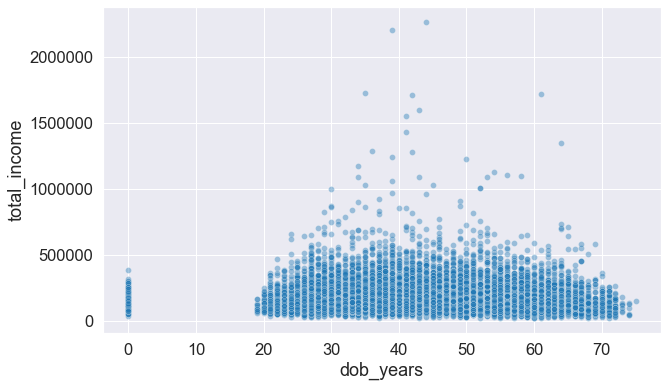

In [15]:
fig, ax = plt.subplots()

sns.scatterplot(data=df, x='dob_years', y='total_income', ax=ax, alpha=.4)

plt.show()

In [16]:
init_df[init_df['dob_years'] < 10]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541.618895,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,-2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,-1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль
...,...,...,...,...,...,...,...,...,...,...,...,...
19829,0,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,жилье
20462,0,338734.868540,0,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья
20577,0,331741.271455,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость
21179,2,-108.967042,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости


Младенцы не должны работать и (тем более) брать кредиты, поэтому нулевые значения в этой колонке я заменю на NaN (чтобы указать на их недостоверность в явном виде, но иметь возможность производить арифметические операции над колонкой). Если в колонке оставить нули, то возникнут проблемы при категоризации клиентов по возрастным группам.

In [17]:
df['dob_years'] = df['dob_years'].where(df['dob_years'] != 0, np.NaN)

# Проверка
df[df['dob_years'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs
99,0,346541.618895,NaN,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль,NaN
149,0,-2664.273168,NaN,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем,2664.273168
270,3,-1872.663186,NaN,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью,1872.663186
578,0,397856.565013,NaN,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости,NaN
1040,0,-1158.029561,NaN,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль,1158.029561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19829,0,NaN,NaN,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,жилье,NaN
20462,0,338734.868540,NaN,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья,NaN
20577,0,331741.271455,NaN,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость,NaN
21179,2,-108.967042,NaN,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости,108.967042


Подозрительные значения присутствуют в колонке `children`:

In [18]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [19]:
# Заменю слишком большие и слишком маленькие значения на NaN
df['children'] = df['children'].where((df['children'] >= 0) & (df['children'] < 10), np.NaN)

In [20]:
df['children'].value_counts()

0.0    14149
1.0     4818
2.0     2055
3.0      330
4.0       41
5.0        9
Name: children, dtype: int64

#### Подозрительные значения в категориальных данных

In [21]:
def value_count_df(df, colnames):
    """
    Выводит подсчет вхождений значений в колонках `colnames` датафрейма `df`

    Args:
        df (pd.DataFrame): датафрейма
        colnames (array_like): список колонок
    """    

    # Уникальные значения в этих колонках
    for col in colnames:
        print(col)
        print(df[col].value_counts())
        print()

In [22]:
# Колонки с категориальными данными
categorial_cols = ['education', 'family_status', 'gender', 'income_type', 'purpose']

value_count_df(df, categorial_cols)

education
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

family_status
женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

gender
F      14236
M       7288
XNA        1
Name: gender, dtype: int64

income_type
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

p

Проблемы с представлением текста наблюдаются в колонках `education` (разный регистр) и `purpose` (разные формулировки и орфографические ошибки). Некорректное значение присутствует в колонке `gender`: 'XNA' (впрочем, только для одного клиента). Обработаю его:

In [23]:
df['gender'] = df['gender'].where(df['gender'] != 'XNA', np.NaN)

In [24]:
# Проверка

df['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

**Вывод**

- В колонке `days_employed` присутствуют отрицательные и положительные значения. Положительные значения вызывают подозрения - они слишком большие и имеют неправдоподобное распределение. Отрицательные значения, взятые по модулю, имеют правдоподобное значение. На основе последних создана колонка `days_employed_abs`, к которой можно обращаться за информацией о трудовом стаже для части клиентов. При этом важно помнить, что мои предположения о природе ошибок в данных могут оказаться некорректными.

- Исходная таблица содержала пропуски в явном виде (NaN) в колонках `days_employed` и `total_income`. При этом для каждого клиента информация либо присутствует сразу в обеих колонках, либо отсутствует (нет клиентов, для которых указан `days_employed`, но не указан `total_income` и наоборот). Значения пропущены для 10% данных. Вряд ли пропуски содержались в данных изначально: информация о трудовом стаже и ежемесячном доходе клиента необходима для оформления кредита. Скорее всего, ошибки имеют технический характер.

- В колонке `dob_years` присутствуют нулевые значения. Они могут привести к проблемам при категоризации клиентов по возрастным группам, а также дают артефакты при построении распределений. По этой пречине я заменил их на NaN: тип данных в колонке изменится на float64, но пропуски будут отмечены явным образом. Аналогично были обработаны выбросы в колонке `children`&

- Некорректное значение присутствует в колонке `gender` для одного из клиентов. Это значение я заменил на NaN (хотя, наверно, можно было и на None)

- В колонках с категориальными данными `education`, `family_status`, `income_type`, `purpose` пропуски отстутствуют, но есть проблемы с форматированием текста. Разберусь с ними в следующих разделах.

### Замена типа данных

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children             21402 non-null float64
days_employed        19351 non-null float64
dob_years            21424 non-null float64
education            21525 non-null object
education_id         21525 non-null int64
family_status        21525 non-null object
family_status_id     21525 non-null int64
gender               21524 non-null object
income_type          21525 non-null object
debt                 21525 non-null int64
total_income         19351 non-null float64
purpose              21525 non-null object
days_employed_abs    15906 non-null float64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.1+ MB


**Вывод**

Здесь, вероятно, предполагается, что я поменяю тип данных в колонках `days_employed` и `total_income` с float64 на int64, потому что значения в них содержатся с избыточной точностью. И сделаю это, например, при помощи метода astype(). Не вижу смысла: во-первых, меня не пугает избыточная точность в этих колонках, а во-вторых, придется заменять NaN на целочисленные значения (зачем?). Готов передумать, если меня кто-нибудь переубедит.

### Обработка дубликатов

Для начала исправлю проблемы с разными регистрами:

In [26]:
df['education'] = df['education'].str.lower()

Дубликаты в данных действительно присутствуют:

In [27]:
df.duplicated().sum()

71

In [28]:
df[df.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs
2849,0.0,NaN,41.0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,покупка жилья для семьи,NaN
3290,0.0,NaN,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,сыграть свадьбу,NaN
4182,1.0,NaN,34.0,высшее,0,гражданский брак,1,F,сотрудник,0,NaN,свадьба,NaN
4851,0.0,NaN,60.0,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,свадьба,NaN
5557,0.0,NaN,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,сыграть свадьбу,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0.0,NaN,64.0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,дополнительное образование,NaN
21032,0.0,NaN,60.0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,заняться образованием,NaN
21132,0.0,NaN,47.0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,ремонт жилью,NaN
21281,1.0,NaN,30.0,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,покупка коммерческой недвижимости,NaN


In [29]:
dublicates_total = df.duplicated(keep=False).sum()

print(f'Всего дублирующихся строчек: {dublicates_total}')

Всего дублирующихся строчек: 137


In [30]:
print(f'Доля всех дубликатов составляет {dublicates_total / df.shape[0]:.2%} от всех данных.')

Доля всех дубликатов составляет 0.64% от всех данных.


Дубликатов среди данных отностиельно немного. Возможно, они появились из-за человеческого фактора. Избавлюсь от них:

In [31]:
df = df.drop_duplicates()

df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs
0,1.0,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028
1,1.0,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754
2,0.0,-5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610
3,3.0,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207
4,0.0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1.0,-4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663
21521,0.0,343937.404131,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN
21522,1.0,-2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888
21523,3.0,-3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705


**Вывод**

- В исходных данных присутствуют дубликаты (в том числе неявные).

- Доля дубликатов от всех данных невелика (<1%). Возможно, они обусловлены человеческим фактором.

- От части неявных дубликатов удалось избавиться приведением всех строк в колонке `education` к нижнему регистру.

- Для поиска и удаления дубликатов использовались стандартные методы pandas: duplicated() и drop_duplicates() соответственно

- Дополнительные дубликаты могут быть выявлены после наведения порядка в колонке `purpose`: сейчас там одни и те же катекории зачастую сформулированы по-разному

### Лемматизация

In [32]:
from pymystem3 import Mystem
m = Mystem()

In [33]:
# Выделяю леммы в значениях 'purpose'
# Для лемматизации используется библиотека pymystem3. По умолчанию pymystem3 выдает
# список лемматизированных слов (слов, сведённых к лемме)
purpose_lemmas = df['purpose'].apply(m.lemmatize)

purpose_lemmas

0                             [покупка,  , жилье, \n]
1                   [приобретение,  , автомобиль, \n]
2                             [покупка,  , жилье, \n]
3                [дополнительный,  , образование, \n]
4                           [сыграть,  , свадьба, \n]
                             ...                     
21520                  [операция,  , с,  , жилье, \n]
21521               [сделка,  , с,  , автомобиль, \n]
21522                              [недвижимость, \n]
21523    [на,  , покупка,  , свой,  , автомобиль, \n]
21524             [на,  , покупка,  , автомобиль, \n]
Name: purpose, Length: 21454, dtype: object

<blockquote> Не придумал, как простым способом избавиться от '\n' в конце каждой строки. Как это можно сделать? </blockquote> 

In [34]:
df['purpose_lemmas'] = purpose_lemmas

/Users/mike/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<blockquote> Так и не понял, как нужно создавать новую колонку, чтобы не получать это предупреждение. Не подскажешь? </blockquote> 

In [35]:
# Проверка
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs,purpose_lemmas
0,1.0,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028,"[покупка, , жилье, \n]"
1,1.0,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754,"[приобретение, , автомобиль, \n]"
2,0.0,-5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610,"[покупка, , жилье, \n]"
3,3.0,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207,"[дополнительный, , образование, \n]"
4,0.0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN,"[сыграть, , свадьба, \n]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1.0,-4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663,"[операция, , с, , жилье, \n]"
21521,0.0,343937.404131,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN,"[сделка, , с, , автомобиль, \n]"
21522,1.0,-2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888,"[недвижимость, \n]"
21523,3.0,-3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705,"[на, , покупка, , свой, , автомобиль, \n]"


**Вывод**

- Данные были лематезированы при помощи библиотеки pymystem3. Среди значений `purpose` было выделены четыре категории.

### Категоризация данных

In [36]:
# Уникальных вхождений немного, поэтому основные категории можно определить на глаз
init_df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [37]:
def purpose_classifier(purpose):
    """
    Функция для категоризации целей получения кредита.
    Категорицазия производится по ключевым словам.

    Args:
        purpose: Строка с леммами

    Returns:
        [str]: Категория
    """    
    if 'жилье' in purpose or 'недвижимость' in purpose:
        return 'недвижимость'
    
    elif 'автомобиль' in purpose:
        return 'автомобиль'

    elif 'образование' in purpose:
        return 'образование'

    elif 'свадьба' in purpose:
        return 'свадьба'

    else:
        return 'неизвестный класс'


In [38]:
purpose_lemmas_class = df['purpose_lemmas'].apply(purpose_classifier)

df['purpose_lemmas_class'] = purpose_lemmas_class

df

/Users/mike/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs,purpose_lemmas,purpose_lemmas_class
0,1.0,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028,"[покупка, , жилье, \n]",недвижимость
1,1.0,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754,"[приобретение, , автомобиль, \n]",автомобиль
2,0.0,-5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610,"[покупка, , жилье, \n]",недвижимость
3,3.0,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207,"[дополнительный, , образование, \n]",образование
4,0.0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN,"[сыграть, , свадьба, \n]",свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1.0,-4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663,"[операция, , с, , жилье, \n]",недвижимость
21521,0.0,343937.404131,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN,"[сделка, , с, , автомобиль, \n]",автомобиль
21522,1.0,-2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888,"[недвижимость, \n]",недвижимость
21523,3.0,-3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль


Среди значений из нового стобца с катекориями отсутствуют значения 'неизвестный класс' (все значения описаны в рамках четырех категорий):

In [39]:
df['purpose_lemmas_class'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

Проверю, не появились ли новые дубликаты после наведения порядка в целях получения кредита:

In [40]:
# Исключаю из рассмотрения колонку purpose_lemmas и purpose
subset = ['children', 'days_employed', 'dob_years', 'education', 'education_id',
          'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
          'total_income', 'days_employed_abs',
          'purpose_lemmas_class']

df.duplicated(subset=subset).sum()

334

А вот и новые публикаты! Похоже, что дубликаты в данных действительно обусловлены человеческим фактором: одни и те же клиенты появляются несколько раз с отличающимися формулировками цели кредита. Но, правда, в описании данных не было сказано, может ли один и тот же кредитор появляться в таблице, если он берет несколько кредитов (для "покупки своего жилья" и для "покупки жилья для сдачи", например).

Уничтожить!

In [41]:
df = df.drop_duplicates(subset)

df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs,purpose_lemmas,purpose_lemmas_class
0,1.0,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028,"[покупка, , жилье, \n]",недвижимость
1,1.0,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754,"[приобретение, , автомобиль, \n]",автомобиль
2,0.0,-5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610,"[покупка, , жилье, \n]",недвижимость
3,3.0,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207,"[дополнительный, , образование, \n]",образование
4,0.0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN,"[сыграть, , свадьба, \n]",свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1.0,-4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663,"[операция, , с, , жилье, \n]",недвижимость
21521,0.0,343937.404131,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN,"[сделка, , с, , автомобиль, \n]",автомобиль
21522,1.0,-2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888,"[недвижимость, \n]",недвижимость
21523,3.0,-3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль


Перестрою заново несколько графиков из введения и добавлю новый (по стобцу `purpose_lemmas_class`):

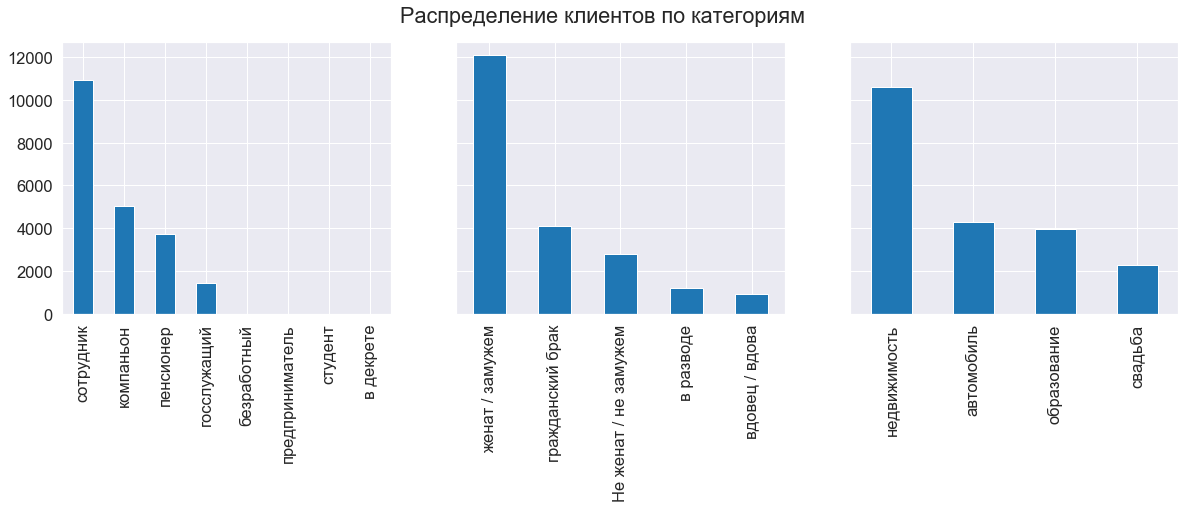

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

df['income_type'].value_counts().plot.bar(ax=ax1)
df['family_status'].value_counts().plot.bar(ax=ax2)
df['purpose_lemmas_class'].value_counts().plot.bar(ax=ax3)

fig.suptitle('Распределение клиентов по категориям')

plt.show()

Радикальных изменений на левом и среднем графике не наблюдается, предварительные качественные выводы остаются в силе. Наибольшее количество кредитов связаны с недвижимостью, второе и третье место делят автомобили и образование. Меньше всего клиентов берут кредиты на свадьбу.

**Вывод**

- Категоризация данных позволила выделить дополнительные дубликаты.
- Наибольшее количество кредитов связаны с недвижимостью.

## Шаг 3. Ответьте на вопросы

Метод: я буду сравнивать относительную долю недобросовестных кредиторов в каждой из целевых групп.

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [43]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'days_employed_abs', 'purpose_lemmas',
       'purpose_lemmas_class'],
      dtype='object')

In [44]:
df['children'].value_counts()

0.0    13829
1.0     4751
2.0     2039
3.0      329
4.0       40
5.0        9
Name: children, dtype: int64

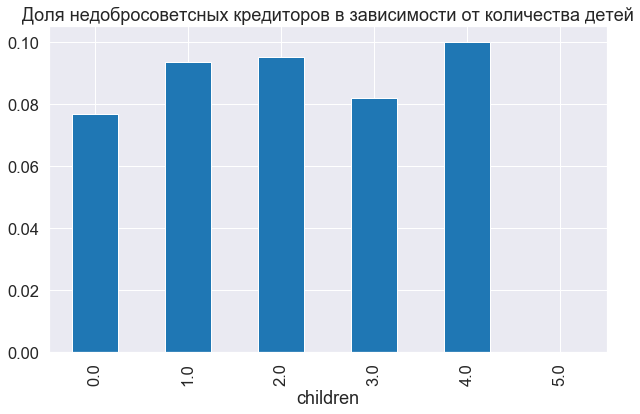

In [45]:
children_fraction = df.groupby('children')['debt'].sum() / df['children'].value_counts()

children_fraction.plot.bar()

plt.title('Доля недобросоветсных кредиторов в зависимости от количества детей')

plt.show()

**Вывод**

Кажется, что наличие детей уменьшает вероятность того, что кредитор вернет деньги банку. Сделать однозначный вывод можно будет после вычисления ошибок на полученные значения. Статистики по кредиторам с 5 детьми недостаточно: в данных таких клиентов всего 9.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
df['family_status'].value_counts()

женат / замужем          12076
гражданский брак          4124
Не женат / не замужем     2784
в разводе                 1193
вдовец / вдова             943
Name: family_status, dtype: int64

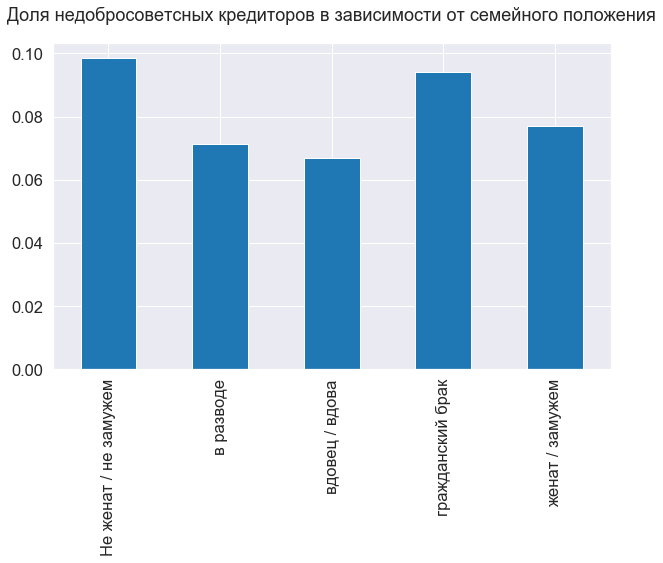

In [47]:
family_fraction = df.groupby('family_status')['debt'].sum() / df['family_status'].value_counts()

family_fraction.plot.bar()

plt.title('Доля недобросоветсных кредиторов в зависимости от семейного положения', y=1.05)

plt.show()

**Вывод**

Хуже всего возвращают кредиты не женатые (не замужние) клиенты и те, кто состоит в гражданском браке. Для более внятных выводов нужно оценивать шум в данных.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для удобства введу категории по уровню дохода

In [48]:
def income_classifier(income):
    """
    Функция для категоризации дохода клиентов.

    Args:
        income: Ежемесячный доход

    Returns:
        [str]: Категория
    """    
    if income < 50000:
        return 'низкий'
    
    elif income > 50000 and income < 150000:
        return 'средний'

    elif income > 150000 and income < 350000:
        return 'высокий'

    elif income > 350000:
        return 'очень высокий'

    else:
        return np.NaN

In [49]:
df['income_class'] = df['total_income'].apply(income_classifier)

df

/Users/mike/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_abs,purpose_lemmas,purpose_lemmas_class,income_class
0,1.0,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,8437.673028,"[покупка, , жилье, \n]",недвижимость,высокий
1,1.0,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,4024.803754,"[приобретение, , автомобиль, \n]",автомобиль,средний
2,0.0,-5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,5623.422610,"[покупка, , жилье, \n]",недвижимость,средний
3,3.0,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,4124.747207,"[дополнительный, , образование, \n]",образование,высокий
4,0.0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,NaN,"[сыграть, , свадьба, \n]",свадьба,высокий
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1.0,-4529.316663,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663,"[операция, , с, , жилье, \n]",недвижимость,высокий
21521,0.0,343937.404131,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,NaN,"[сделка, , с, , автомобиль, \n]",автомобиль,высокий
21522,1.0,-2113.346888,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888,"[недвижимость, \n]",недвижимость,средний
21523,3.0,-3112.481705,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль,высокий


In [50]:
df['income_class'].value_counts()

средний          9795
высокий          8326
очень высокий     858
низкий            372
Name: income_class, dtype: int64

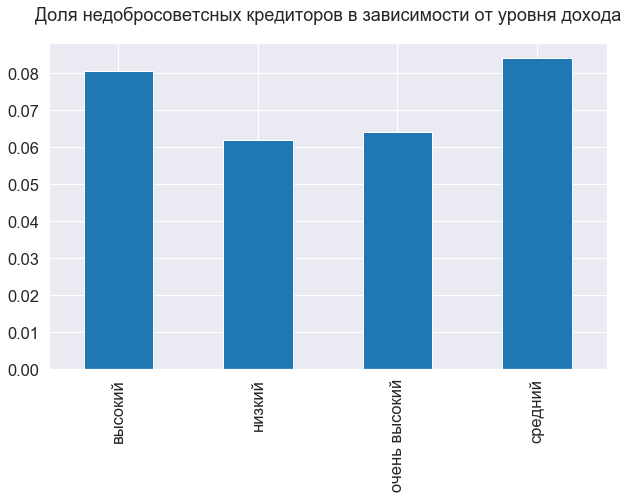

In [51]:
income_fraction = df.groupby('income_class')['debt'].sum() / df['income_class'].value_counts()

income_fraction.plot.bar()

plt.title('Доля недобросоветсных кредиторов в зависимости от уровня дохода', y=1.05)

plt.show()

**Вывод**

Хуже всего возвращают кредиты клиенты с высоким и средним уровнем дохода. Лучше справляются кредиторы с низким и очень высоким доходом.

- Как разные цели кредита влияют на его возврат в срок?

In [52]:
df['purpose_lemmas_class'].value_counts()

недвижимость    10578
автомобиль       4272
образование      3964
свадьба          2306
Name: purpose_lemmas_class, dtype: int64

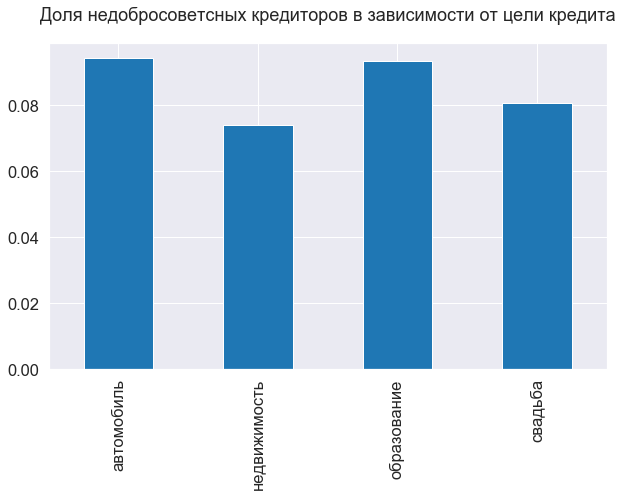

In [53]:
purpose_fraction = df.groupby('purpose_lemmas_class')['debt'].sum() / df['purpose_lemmas_class'].value_counts()

purpose_fraction.plot.bar()

plt.title('Доля недобросоветсных кредиторов в зависимости от цели кредита', y=1.05)

plt.show()

**Вывод**

Больше всего недобросовестных кредиторов среди тех, кто занимает деньги на цели связанные с автомобилем и образованием. Лучше всех справляются кредиторы, берущие кредиты на недвижимость.

## Шаг 4. Общий вывод

В работе была исследованны зависимости погашения кредита в срок от разных факторов (наличие детей, семейный статус, уровень дохода, цель кредита) на основе информации о ~20 тыс. клиентов.

Исходные данные содержали пропуски и выбросы, которые были обработаны перед проведением анализа. По результатам анализа сделаны следующие выводы:

- **Количество детей |** Наличие детей уменьшает вероятность того, что кредитор вернет деньги банку. От количества детей эта вероятность зависит несущественно.
- **Семейный статус |** Хуже остальных возвращают кредиты не женатые (не замужние) клиенты и те, кто состоит в гражданском браке.
- **Уровень дохода |** Хуже всего возвращают кредиты клиенты с высоким и средним уровнем дохода. Лучше справляются кредиторы с низким и очень высоким доходом.
- **Цель кредита |** Больше всего недобросовестных кредиторов среди тех, кто занимает деньги на цели связанные с автомобилем и образованием. Лучше всех справляются кредиторы, берущие кредиты на недвижимость.

Для формулировки окончательного вывода необходимо оценить уровень шума в данных и указать ошибки на полученные метрики.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [ ]  заменен вещественный тип данных на целочисленный;
- [ ]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации (_не очень понял, что здесь требуется, написа пару слов про библиотеку pymystem3_);
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- []  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.